In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from matplotlib.cm import rainbow
from joblib import Parallel, delayed

from scipy.stats import pearsonr

In [2]:
input_data = pd.read_csv('STORAGE_data/AUDCAD.csv')
input_data

,instrument,time,open,high,low,close,volume,average,barCount
0,11,2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025,-1.0,-1.0,-1
1,11,2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065,-1.0,-1.0,-1
2,11,2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090,-1.0,-1.0,-1
3,11,2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145,-1.0,-1.0,-1
4,11,2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...
1107386,11,2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965,-1.0,-1.0,-1
1107387,11,2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035,-1.0,-1.0,-1
1107388,11,2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935,-1.0,-1.0,-1
1107389,11,2021-11-13 00:58:00,0.919935,0.919995,0.919900,0.919900,-1.0,-1.0,-1


In [3]:
input_data.index = pd.to_datetime(input_data.time)
input_data

,instrument,time,open,high,low,close,volume,average,barCount
time,,,,,,,,,
2018-11-01 00:15:00,11,2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025,-1.0,-1.0,-1
2018-11-01 00:16:00,11,2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065,-1.0,-1.0,-1
2018-11-01 00:17:00,11,2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090,-1.0,-1.0,-1
2018-11-01 00:18:00,11,2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145,-1.0,-1.0,-1
2018-11-01 00:19:00,11,2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...
2021-11-13 00:55:00,11,2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965,-1.0,-1.0,-1
2021-11-13 00:56:00,11,2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035,-1.0,-1.0,-1
2021-11-13 00:57:00,11,2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935,-1.0,-1.0,-1


In [4]:
data = input_data.drop(['instrument', 'time', 'volume', 'average', 'barCount'], axis=1)

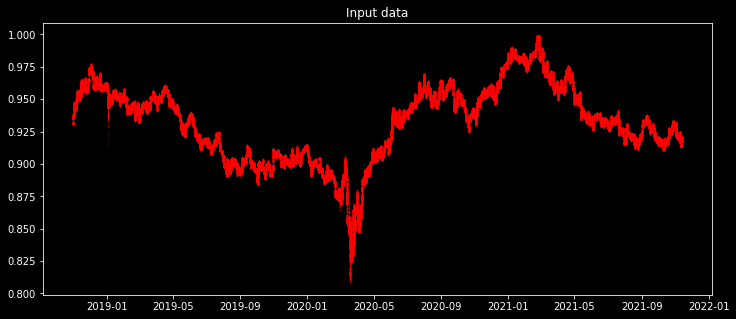

In [5]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [6]:
def pearson_corr(a,b):
    """
    Better to use scipy
    :param a:
    :param b:
    :return:
    """
    a_hat = np.mean(a)
    b_hat = np.mean(b)
    return np.sum(np.subtract(a, a_hat) * np.subtract(b, b_hat)) / np.sqrt(np.sum(np.square(np.subtract(a, a_hat))) * np.sum(np.square(np.subtract(b, b_hat))))

def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 59 - 29
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    #   Shows percent of "bad" dotes
    print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    return inp_data.loc[mask,:]


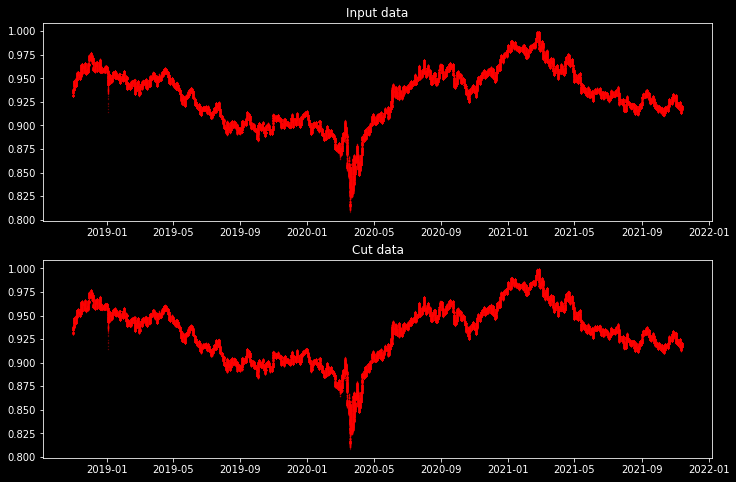

Bad days at 0.00% observations


In [7]:
preprocessed_data = normalize_data(data).close.values

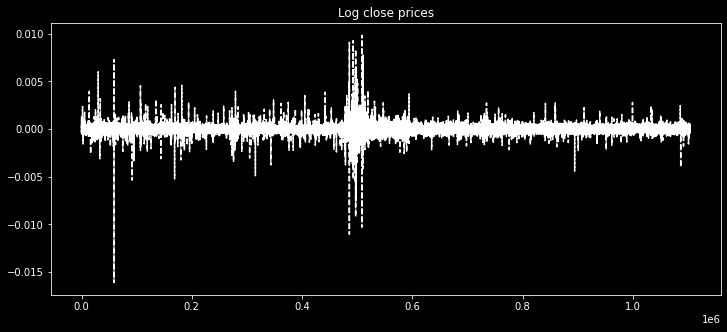

In [8]:
preprocessed_data = np.log((preprocessed_data / np.roll(preprocessed_data, 1))[1:])
plt.figure(figsize=(12,5))
plt.title('Log close prices')
plt.plot(preprocessed_data, '--', color='white')
plt.show()

In [9]:
# preprocessed_data = (np.diff(preprocessed_data) / preprocessed_data[:-1])[1:]
# plt.figure(figsize=(12,5))
# plt.title('Log close prices')
# plt.plot(preprocessed_data, '--', color='white')
# plt.show()


In [10]:
"""
CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
_LOOKBACK_MASK_ = np.arange(20, 2000, 5)
_HOLD_MASK_ = np.arange(20, 2000, 5)
LB_SIMPLIFY = 10
for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
    for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
        PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)
"""

'\nCORRELATION_DF = pd.DataFrame(columns=[\'Pair\',\'LOOKBACK\',\'HOLD\',\'Correlation\', \'P_VALUE\'])\n_LOOKBACK_MASK_ = np.arange(20, 2000, 5)\n_HOLD_MASK_ = np.arange(20, 2000, 5)\nLB_SIMPLIFY = 10\nfor WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc=\'WINDOWS_LOOKBACK\'):\n    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK\n    for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc=\'WINDOW_HOLD\'):\n        HOLD_ALL_DATA = list()\n        LOOKBACK_ALL_DATA = list()\n        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):\n            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):\n                # print(\'READY\')\n                # print(LB_SAMPLE)\n                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)\n                # print(WINDOW_HOLD)\n                # print(len(preprocessed_data))\n                break\n            else:\n                #   View like [ 20000 20020 ][ 20020 20040 ]\n                LOOKBACK = preprocessed_data[LB_S

In [11]:
def create_corr_table(preprocessed_data):
    print(np.any(np.isnan(preprocessed_data)))
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(20, 120, 5)
    _HOLD_MASK_ = np.arange(20, 2400, 90)
    LB_SIMPLIFY = 10
    for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):

        LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
        for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
            HOLD_ALL_DATA = list()
            LOOKBACK_ALL_DATA = list()
            for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
                if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                    # print('READY')
                    # print(LB_SAMPLE)
                    # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                    # print(WINDOW_HOLD)
                    # print(len(preprocessed_data))
                    break
                else:
                    #   View like [ 20000 20020 ][ 20020 20040 ]
                    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                    HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                    HOLD_ALL_DATA.append(sum(HOLD))
                    LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
                #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
            PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
            CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df = create_corr_table(preprocessed_data=preprocessed_data[preprocessed_data != np.inf])
df

False


WINDOWS_LOOKBACK:   0%|          | 0/20 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
df.LOOKBACK.max()

NameError: name 'df' is not defined

In [ ]:
df.LOOKBACK = df.LOOKBACK.astype(int)
df.HOLD = df.HOLD.astype(int)
df

In [ ]:
df[(df.HOLD > 100) & (df.LOOKBACK < 15)]

In [13]:
def creator(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY):
    RETURN_LIST = list()
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK

    ### Not sure that works. Test
    if LB_SAMPLES<LB_SIMPLIFY:
        LB_SIMPLIFY = 1
    ###


    for WINDOW_HOLD in _HOLD_MASK_:
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')

        try:
            PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        except ValueError:
            print('Value Error')
            print(LOOKBACK_ALL_DATA)
            print(HOLD_ALL_DATA)
            print(LB_SAMPLES)
            print(LB_SIMPLIFY)
        RETURN_LIST.append({'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]})
    return RETURN_LIST

def threading_create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(50, 1200, 100)
    _HOLD_MASK_ = np.arange(2, 120, 5)
    LB_SIMPLIFY = 10

    assets = Parallel(n_jobs=-1, verbose=10)(delayed(creator)(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY) for WINDOW_LOOKBACK in _LOOKBACK_MASK_)
    for _ in assets:
        for __ in _:
            CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)

    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df2 = threading_create_corr_table(preprocessed_data=preprocessed_data)
#df2.query('Correlation < 0.7')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   12.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   12.2s remaining:    4.1s


KeyboardInterrupt: 

# Back one

In [24]:
def threading_create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(50, 1200, 100)
    _HOLD_MASK_ = np.arange(2, 120, 5)
    LB_SIMPLIFY = 10

    assets = Parallel(n_jobs=-1, verbose=10, backend='multiprocessing')(delayed(creator)(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY) for WINDOW_LOOKBACK in _LOOKBACK_MASK_)
    for _ in assets:
        for __ in _:
            CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)

    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)


df2 = threading_create_corr_table(preprocessed_data=preprocessed_data)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/joblib/pool.py", line 147, in get
    return recv()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 256, in recv
    return _ForkingPickler.loads(buf.getbuffer())

KeyboardInterrupt: 

# Block 2

In [61]:
def threading_create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(50, 1200, 100)
    _HOLD_MASK_ = np.arange(2, 120, 5)
    LB_SIMPLIFY = 10

    assets = Parallel(n_jobs=-1, verbose=0, backend='threading')(delayed(creator)(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY) for WINDOW_LOOKBACK in _LOOKBACK_MASK_)
    for _ in assets:
        for __ in _:
            CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)

    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)


%timeit -r10 df2 = threading_create_corr_table(preprocessed_data=preprocessed_data)

4.12 s ± 622 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


# Block 3

In [55]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

creator_filled = partial(creator, _HOLD_MASK_=np.arange(2, 120, 5), preprocessed_data=preprocessed_data,LB_SIMPLIFY=10)

def _(creator_filled):
    _LOOKBACK_MASK_ = np.arange(50, 1200, 100)
    with ThreadPoolExecutor(4) as executor:
        results = executor.map(creator_filled, _LOOKBACK_MASK_)
    return list(results)

%timeit -n 10
results = _(creator_filled)
results = _(creator_filled)

In [48]:
CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
for _ in list(results):
    for __ in _:
        CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)
CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
253,L-1050;H-67,1050,67,0.260461,0.007007
250,L-1050;H-52,1050,52,0.239981,0.013220
252,L-1050;H-62,1050,62,0.229450,0.017982
251,L-1050;H-57,1050,57,0.222657,0.021785
249,L-1050;H-47,1050,47,0.216308,0.025944
...,...,...,...,...,...
221,L-950;H-27,950,27,-0.344456,0.000143
204,L-850;H-62,850,62,-0.353133,0.000038
203,L-850;H-57,850,57,-0.355927,0.000032
220,L-950;H-22,950,22,-0.372863,0.000035


In [37]:
df2

,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
253,L-1050;H-67,1050,67,0.260461,0.007007
250,L-1050;H-52,1050,52,0.239981,0.013220
252,L-1050;H-62,1050,62,0.229450,0.017982
251,L-1050;H-57,1050,57,0.222657,0.021785
249,L-1050;H-47,1050,47,0.216308,0.025944
...,...,...,...,...,...
221,L-950;H-27,950,27,-0.344456,0.000143
204,L-850;H-62,850,62,-0.353133,0.000038
203,L-850;H-57,850,57,-0.355927,0.000032
220,L-950;H-22,950,22,-0.372863,0.000035


In [ ]:

df2

In [ ]:
df = df2
from matplotlib import cm
ax = plt.figure(figsize=(18,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('Lookback')
ax.set_ylabel('Hold')
ax.set_zlabel('Correlation')
X, Y = np.meshgrid(df['LOOKBACK'].astype(float), df['HOLD'].astype(float))
ax.scatter(df['LOOKBACK'].astype(float), df['HOLD'].astype(float), df['Correlation'],c=df['Correlation'], cmap=plt.get_cmap('winter'))

In [ ]:
plt.figure(figsize=(18,10))
plt.scatter(df['LOOKBACK'].astype(int), df['HOLD'].astype(int), c=df['Correlation'], cmap=plt.get_cmap('jet'))
plt.xlabel('LOOKBACK')
plt.ylabel('HOLD')
plt.colorbar()


In [ ]:
df

In [ ]:
#   Testing that A U B == 0
plt.figure(figsize=(14,6))
LB_SIMPLIFY = 1
WINDOW_LOOKBACK = 90_000
LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
colors = rainbow(np.linspace(0,1, len(range(0, LB_SAMPLES, LB_SIMPLIFY))))
for i, LB_SAMPLE in enumerate(range(0, LB_SAMPLES, LB_SIMPLIFY)):
    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
    plt.plot([j for j in range(LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK)], LOOKBACK,'--', color=colors[i])
plt.show()
